## Normalizing Flows

Your task is to implement a version of Normalizing Flow for image generation. Our implementation will be based on RealNVP (https://arxiv.org/pdf/1605.08803.pdf) and we will be training on one class from MNIST. Your task is to read the paper in details and implement simple version of the algorithm from the paper:


1. Implement simple CouplingLayers (see RealNVP paper) with neural networks using a few fully connected layers with hidden activations of your choice. More on the CouplingLayers can be also found in https://arxiv.org/pdf/1410.8516.pdf. Remember to implement properly logarithm of a Jacobian determinant calculation. Implement only single scale architecture, ignore multiscale architecture with masked convolution and batch normalization. (2 points)
2. Implement RealNVP class combining many CouplingLayers with proper masking pattern (rememeber to alternate between unmodified pixels) with forward and inverse flows. (1 points)
3. Implement a loss function `nf_loss` (data log-likelihood) for the model. Hint: check `torch.distributions` (1 point)
4. Train your model to achieve good looking samples (similar to training set) and average per sample likelihood on training set lower than -1700. (2 points)
5. Sample from your model and pick 2 images (as visually different as possible) from your samples and plot 10 images that correspond to equally spaced linear interpolations in latent space between those images you picked. (1 point)
6. Use method from section 5.2 from https://arxiv.org/pdf/1410.8516.pdf with trained model and inpaint 5 sampled images with different random parts of your image occluded (50% of the image must be occluded). (2 point)
7. Write a report describing your solution, add loss plots and samples from the model. Write which hyperparameter sets worked for you and which did not. (1 point)

In [4]:
! pip install clearml > /dev/null 2>&1

In [5]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from torch import distributions
from clearml import Task

In [6]:
def plot(samples):
    length = len(samples)
    fig, ax = plt.subplots(1, length, figsize=(2*length, 2))
    fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    for j in range(length):
        ax[j].imshow(samples[j].cpu().numpy())
        ax[j].axis('off')
    plt.show()


class Coupling_layer(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, mask):
        super(Coupling_layer, self).__init__()
        self.scale_block = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), 
                                         nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), 
                                         nn.Linear(hidden_dim, output_dim), nn.Tanh())
        self.transform_block = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), 
                                             nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), 
                                             nn.Linear(hidden_dim, output_dim))
        self.mask = mask

    def forward_flow(self, x):
        x_m = x * self.mask
        s_out = self.scale_block(x_m)
        t_out = self.transform_block(x_m)
        y = x_m + (1 - self.mask) * (x * torch.exp(s_out) + t_out)
        logdetJ = torch.sum(s_out, dim=1)
        return y, logdetJ
        

    def inverse_flow(self, z):
        z_m = z * self.mask
        s_out = self.scale_block(z_m)
        t_out = self.transform_block(z_m)
        x = z_m + (1 - self.mask) * (z - t_out) * torch.exp(-s_out)
        return x


class RealNVP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, mask, num_layers):
        super(RealNVP, self).__init__()
        assert num_layers >= 2
        self.modules = []
        self.modules.append(Coupling_layer(input_dim, output_dim, hidden_dim, 1 - mask))
        for i in range(num_layers - 2):
          if i % 2 == 0:
            self.modules.append(Coupling_layer(input_dim, output_dim, hidden_dim, 1 - mask))
          else: 
            self.modules.append(Coupling_layer(input_dim, output_dim, hidden_dim, mask))
        self.modules.append(Coupling_layer(input_dim, output_dim, hidden_dim, mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward_flow(self, x):
        x = torch.flatten(x, start_dim=1)
        logdetJ = 0
        for layer in self.module_list:
            x, logdetJ_ = layer.forward_flow(x)
            logdetJ += logdetJ_
        return x, logdetJ

    def inverse_flow(self, z):
        z = torch.flatten(z, start_dim=1)
        for layer in reversed(self.module_list):
            z = layer.inverse_flow(z)
        z = z.view(z.shape[0], 28, 28)
        return z
    

def nf_loss(z, logdetJ):
    loss = - (prior_z.log_prob(z) + logdetJ).mean()
    return loss

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = torchvision.datasets.MNIST(root=r'./mnist/', 
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)
x = (dataset.data.float() / 255. - 0.5)
y = dataset.targets
x = x[y == 5]

dataloader = DataLoader(x, batch_size=128, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [6]:
web_server = 'https://app.community.clear.ml'
api_server = 'https://api.community.clear.ml'
files_server = 'https://files.community.clear.ml'
access_key = ' 2AMBQZZKU0MHQN8LPWBU'#@param {type:"string"}
secret_key = ' 5CYq7ylA960GKRQ8mkJvPs85cL1GRddG35kqp33BOEerVmlKKj'#@param {type:"string"}

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

In [7]:
task = Task.init(project_name='normalizing_flows', task_name='log6')

ClearML Task: overwriting (reusing) task id=404ce6eff0394140a5cc1eea07d8b933
2022-05-30 15:13:43,952 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.community.clear.ml/projects/42a143eda77d4fe0a40e424649ebd6dd/experiments/404ce6eff0394140a5cc1eea07d8b933/output/log


In [8]:
params = {
    'n_epochs': 500,
    'lr': 1e-4,
    'eps': 1e-5,
    'num_layer': 8,
    'hidden_dim': 28*28*2
}

In [9]:
task.mark_started()
logger = task.get_logger()
task.connect(params)

{'eps': 1e-05,
 'hidden_dim': 1568,
 'lr': 0.0001,
 'n_epochs': 500,
 'num_layer': 8}

In [10]:
mask = torch.concat([torch.ones((28*28)//2), torch.zeros((28*28)//2)]).to(device)

model = RealNVP(input_dim=784, output_dim=784, hidden_dim=params['hidden_dim'], mask=mask, num_layers=params['num_layer']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], eps=params['eps'])

prior_z = distributions.MultivariateNormal(torch.zeros(784).to(device), torch.eye(784).to(device))

Epoch: 0/500 Loss: -2103.3154


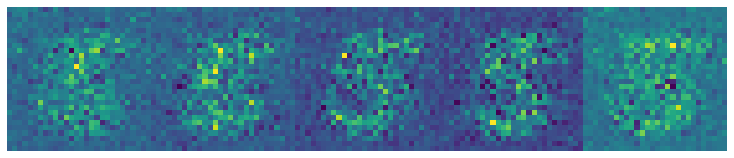

Epoch: 10/500 Loss: -4170.2245


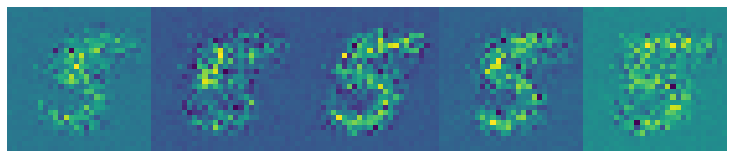

Epoch: 20/500 Loss: -4449.5931


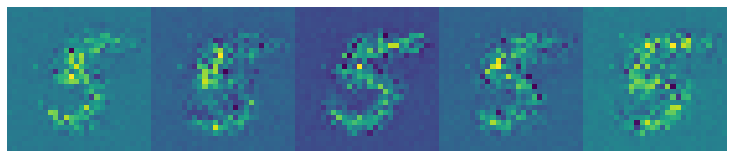

Epoch: 30/500 Loss: -4535.5028


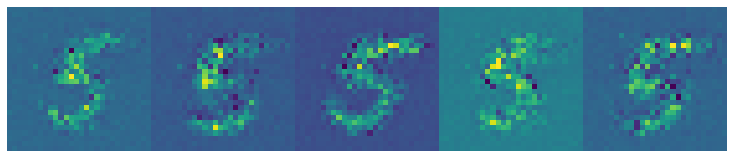

Epoch: 40/500 Loss: -4585.8495


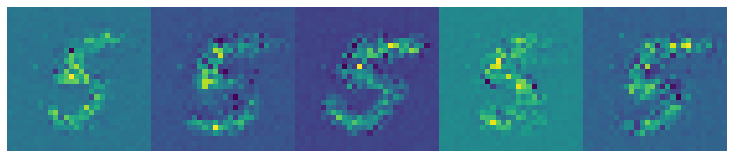

Epoch: 50/500 Loss: -4623.1930


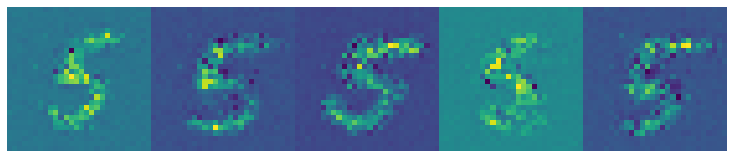

Epoch: 60/500 Loss: -4653.3570


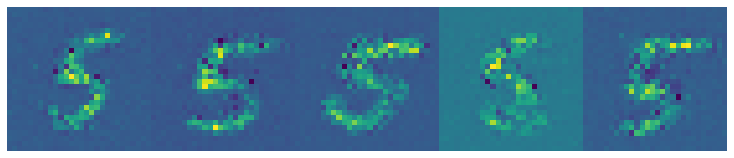

Epoch: 70/500 Loss: -4675.4653


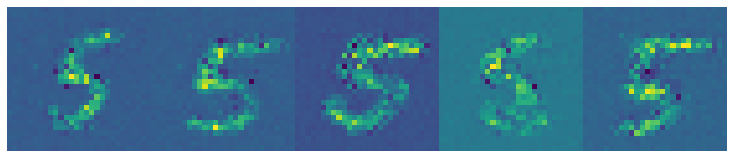

Epoch: 80/500 Loss: -4696.1104


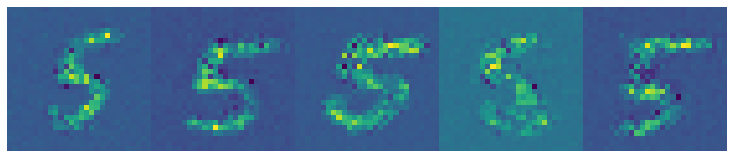

Epoch: 90/500 Loss: -4706.5630


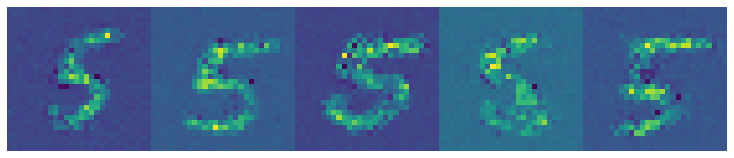

Epoch: 100/500 Loss: -4725.9426


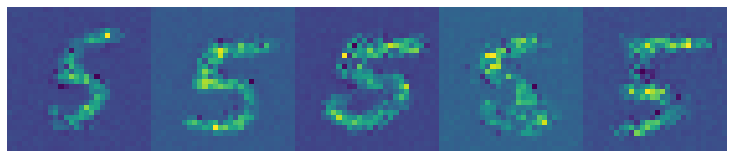

Epoch: 110/500 Loss: -4740.8897


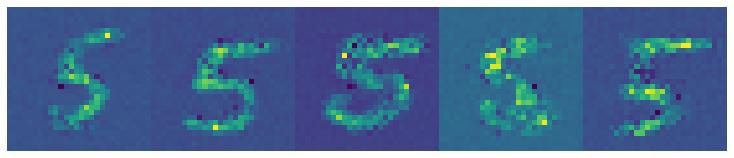

Epoch: 120/500 Loss: -4750.6135


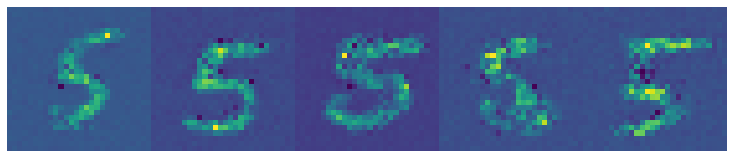

Epoch: 130/500 Loss: -4754.6369


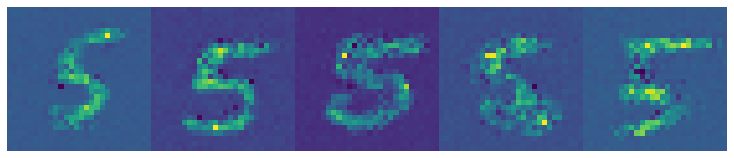

Epoch: 140/500 Loss: -4771.9718


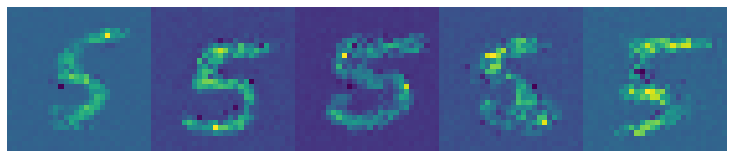

Epoch: 150/500 Loss: -4779.7032


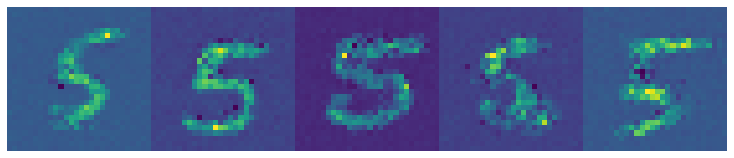

Epoch: 160/500 Loss: -4786.5026


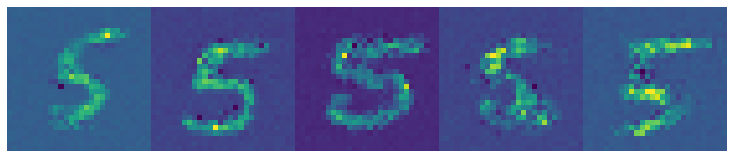

Epoch: 170/500 Loss: -4795.3043


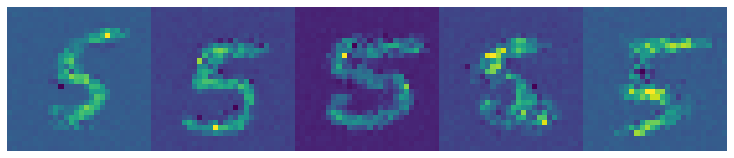

Epoch: 180/500 Loss: -4804.5835


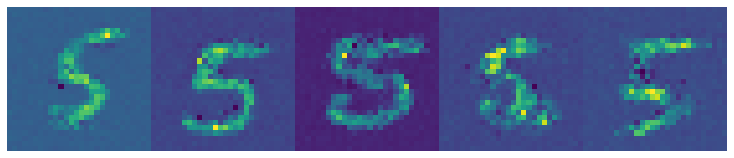

Epoch: 190/500 Loss: -4810.0247


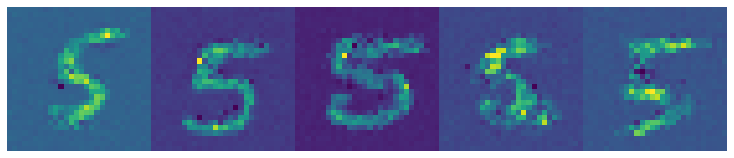

Epoch: 200/500 Loss: -4812.2948


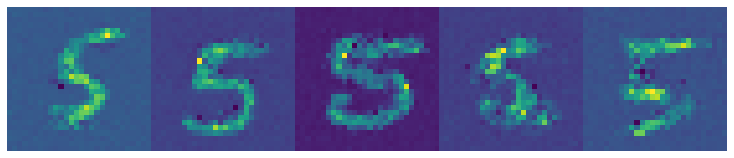

Epoch: 210/500 Loss: -4816.2675


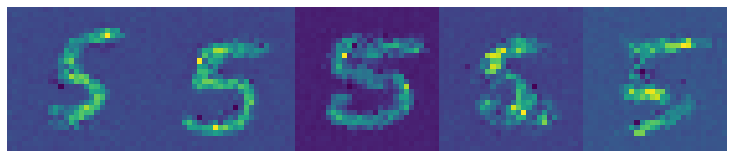

Epoch: 220/500 Loss: -4828.2298


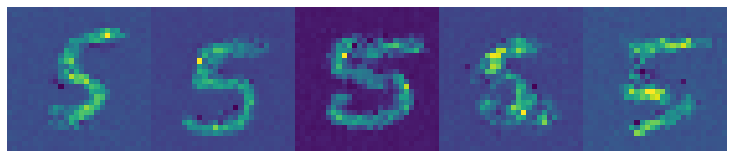

Epoch: 230/500 Loss: -4831.3400


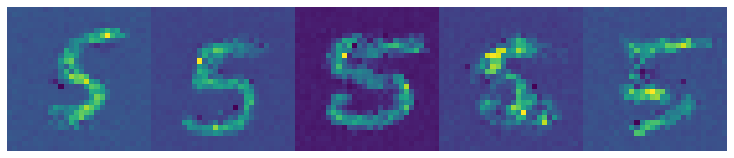

Epoch: 240/500 Loss: -4835.3340


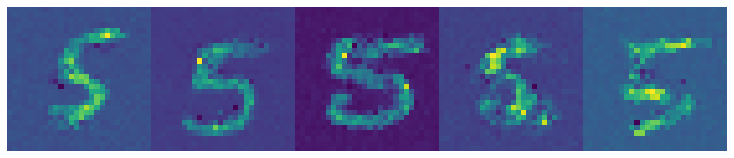

Epoch: 250/500 Loss: -4842.4259


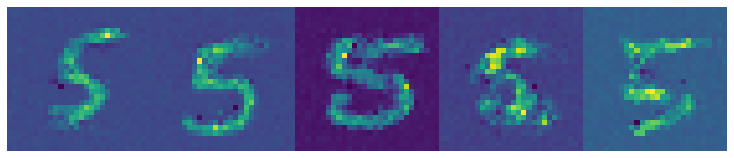

Epoch: 260/500 Loss: -4848.5436


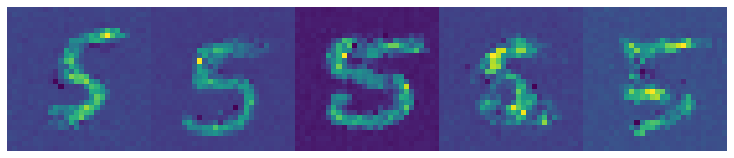

Epoch: 270/500 Loss: -4851.3578


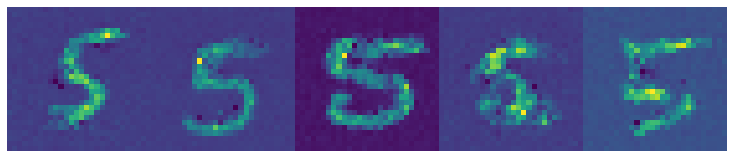

Epoch: 280/500 Loss: -4855.3127


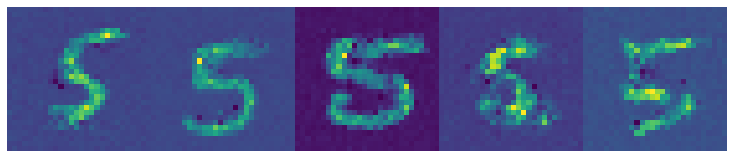

Epoch: 290/500 Loss: -4858.1442


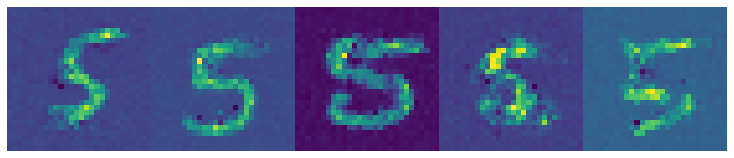

Epoch: 300/500 Loss: -4865.4022


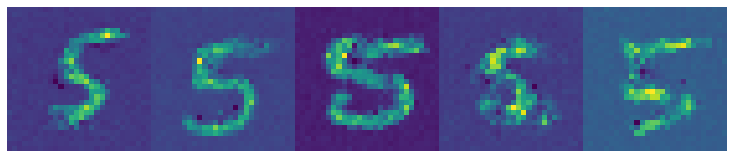

Epoch: 310/500 Loss: -4865.4411


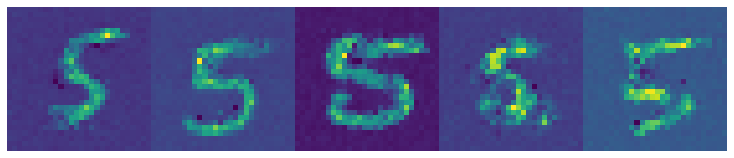

Epoch: 320/500 Loss: -4865.4227


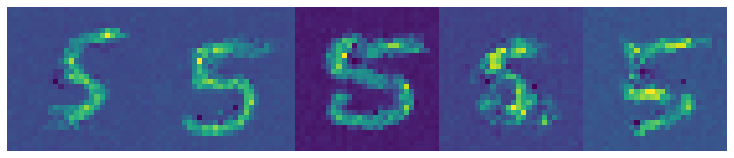

Epoch: 330/500 Loss: -4873.7809


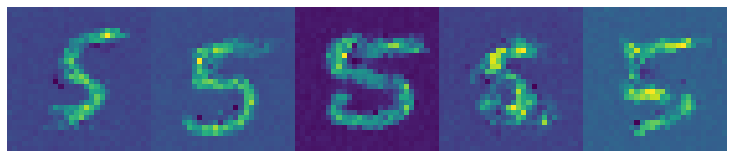

Epoch: 340/500 Loss: -4877.0398


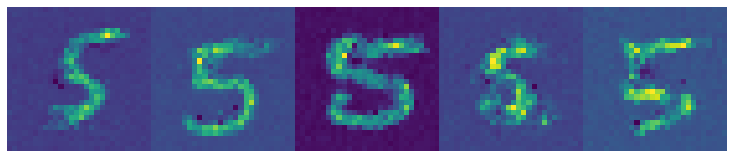

Epoch: 350/500 Loss: -4880.3469


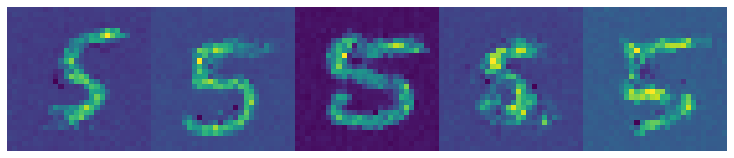

Epoch: 360/500 Loss: -4881.7598


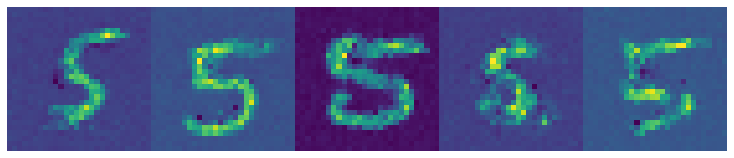

Epoch: 370/500 Loss: -4886.0879


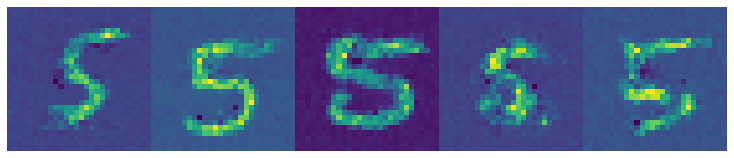

Epoch: 380/500 Loss: -4889.8456


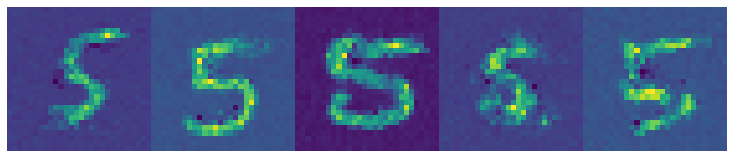

Epoch: 390/500 Loss: -4893.4469


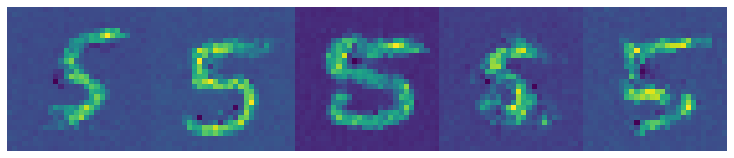

Epoch: 400/500 Loss: -4896.3939


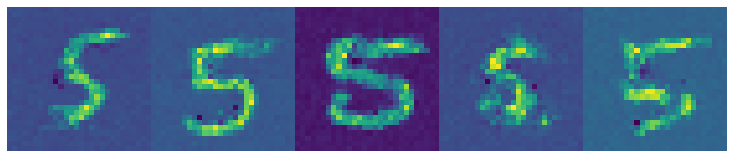

Epoch: 410/500 Loss: -4897.6433


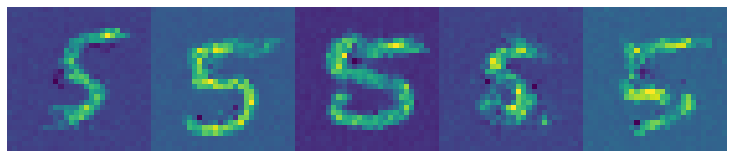

Epoch: 420/500 Loss: -4901.3041


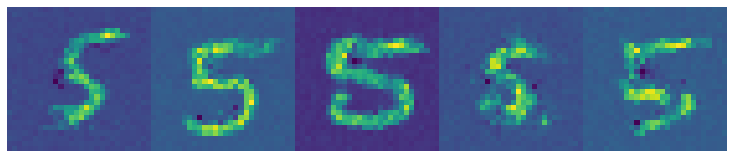

Epoch: 430/500 Loss: -4903.2678


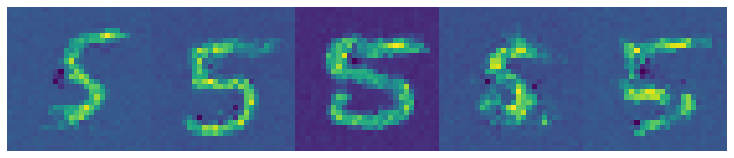

Epoch: 440/500 Loss: -4904.5423


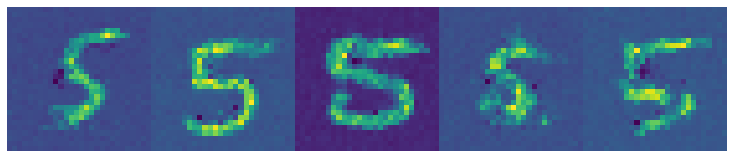

Epoch: 450/500 Loss: -4908.4296


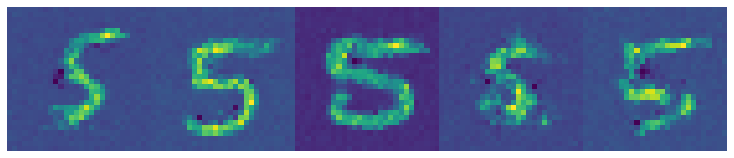

Epoch: 460/500 Loss: -4909.2861


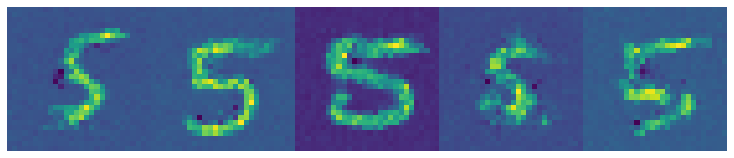

Epoch: 470/500 Loss: -4911.9828


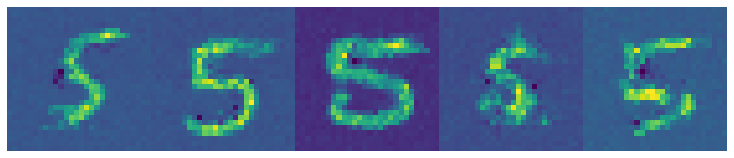

Epoch: 480/500 Loss: -4912.5841


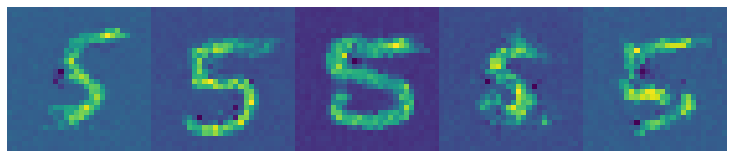

Epoch: 490/500 Loss: -4916.7040


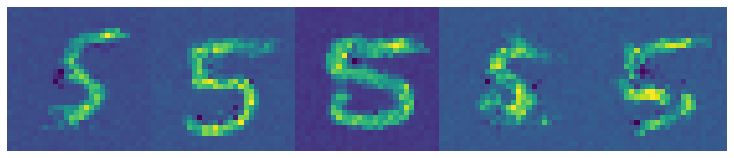

In [11]:
sample_noise = torch.randn(5,28,28).to(device)

for i in range(params['n_epochs']):
    model.train()
    loss_acc = 0
    for j, x in enumerate(dataloader):
        optimizer.zero_grad()
        x = (x.float() + torch.randn(x.shape) / 64.).to(device)
        z, logdetJ = model.forward_flow(x)
        loss = nf_loss(z, logdetJ)
        loss_acc += loss.item()
        loss.backward()
        optimizer.step()
        logger.report_scalar(title='Loss', series='Train', iteration=i, value=(loss_acc / (j+1)))
    
    if i%10 == 0:
        print(f'Epoch: {i}/{params["n_epochs"]} Loss: {(loss_acc / (j+1)):.4f}')
        with torch.no_grad():
            model.eval()
            samples = model.inverse_flow(sample_noise)
            plot(samples)

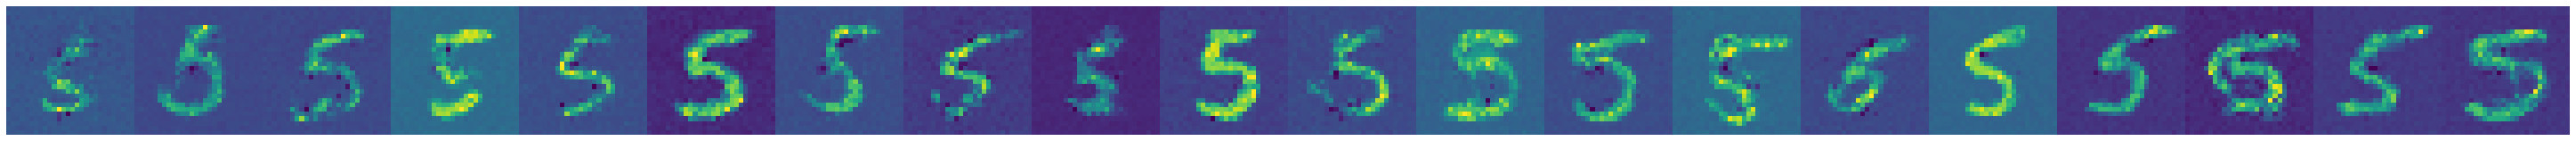

In [17]:
sample_noise = torch.randn(20,28,28).to(device)
with torch.no_grad():
    model.eval()
    samples = model.inverse_flow(sample_noise)
    plot(samples)

In [18]:
torch.save(model.state_dict(), "normalizing_flows.ckpt")

In [19]:
task.mark_completed()
task.close()

In [47]:
z1 = samples[17].unsqueeze(0)

In [48]:
z2 = samples[5].unsqueeze(0)

In [54]:
seq_len = 11
difference = (z2 - z1) / seq_len

seq = [z1 + k * difference for k in range(seq_len + 1)]
seq = torch.cat(seq, dim=0)

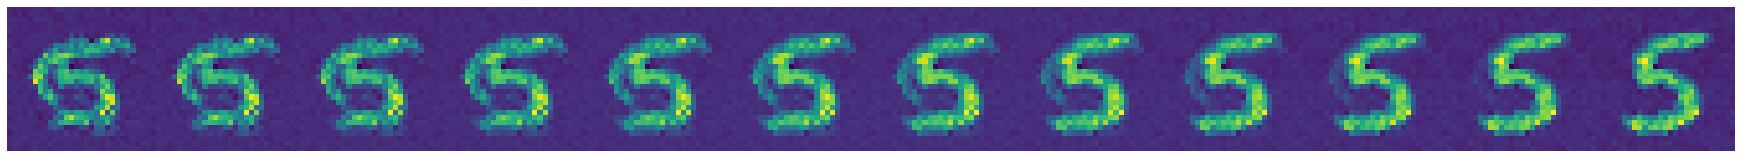

In [61]:
with torch.no_grad():
    model.eval()
    samples = model.inverse_flow(sample_noise)
    plot(seq)

In [8]:
for j, x in enumerate(dataloader):
  images = x
  break

In [110]:
x = images[0:2]
x = (x.float() + torch.randn(x.shape) / 64.).to(device)

In [27]:
x.shape

torch.Size([2, 28, 28])

In [137]:
class Occlude(object):
    def __init__(self, s_min=0.02, s_max=0.04, r_min=0.3):
        self.s_min = s_min
        self.s_max = s_max
        self.r_min = r_min
        self.r_max = 1./r_min

    def __call__(self, tensor):
        result = tensor.clone()
        for i in range(tensor.shape[0]):
          while True:
              Se = np.random.uniform(self.s_min,self.s_max) * 28 * 28
              re = np.random.uniform(self.r_min, self.r_max)
              He, We = 14, 14
              xe, ye = np.random.uniform(0,28), np.random.uniform(0,28)
              if int(xe + We) <= 28 and int(ye + He) <= 28:
                  result[i, int(ye):int(ye + He), int(xe):int(xe + We)].fill_(np.random.uniform())
                  break
        return result

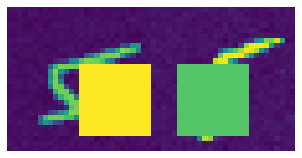

In [144]:
occlude = Occlude()
plot(occlude(x))